In [167]:
import sys
sys.path.insert(0, "../..")

In [168]:
import numpy as np
from matplotlib import pyplot as plt

from module.base.network import Network

from module.components.discrete_gaussian1D import DiscreteGaussian1D
from module.components.discrete_gaussian2D import DiscreteGaussian2D
from module.components.lawrence_dist import LawrenceDist

from module.simulation.meanfield import MeanField
from module.simulation.set_meanfield2 import SetMeanField2

import module.components.CONST as CONST

In [205]:
net = Network(3,3,1, [[0,0,0], [1,1,0]])
net.set_voltage_config([0.1, -0.04], 0)

mf = MeanField(net)

g2 = DiscreteGaussian2D()
g1 = DiscreteGaussian1D()

In [206]:
means = np.zeros(net.N_particles)
vars = np.ones(net.N_particles) * 0.1

In [207]:
neighbour_table = net.get_nearest_neighbours(np.arange(0, net.N_particles))

covs = np.zeros((net.N_particles, 6))
def get_cov(i, j):
    table_index = np.where(neighbour_table[i] == j)[0]
    if table_index.shape[0] == 0:
        return 0

    return covs[i, table_index[0]]

def set_cov(i, j, value):
    table_index = np.where(neighbour_table[i] == j)[0]
    if table_index.shape[0] == 1:
        covs[i, table_index[0]] = value

    table_index = np.where(neighbour_table[j] == i)[0]
    if table_index.shape[0] == 1:
        covs[j, table_index[0]] = value

---

In [208]:
def calc_effective_states(i, j):
    phase_space = g2.phase_space
    states = np.repeat(np.expand_dims(means, axis = [0, 1]), phase_space.shape[0], axis = 0)
    states = np.repeat(states, phase_space.shape[1], axis = 1)

    states[:,:,i] = phase_space[:,:,0]
    states[:,:,j] = phase_space[:,:,1]
    
    return states

In [209]:
def calc_R_island(i, j):
    states = calc_effective_states(i, j)
    rates = net.calc_rate_island(states, i, j)
    return rates

def calc_R_island_inv(i, j):
    states = calc_effective_states(i, j)
    rates = net.calc_rate_island(states, j, i)
    return rates

In [210]:
def calc_R_from_electrode(electrode_index):
    phase_space = g1.phase_space
    states = np.expand_dims(means, axis = 0)
    states = np.repeat(states, phase_space.shape[0], axis = 0)

    island_index = net.get_linear_indices(net.electrode_pos[electrode_index])
    states[:, island_index] = phase_space
    rates = net.calc_rate_from_electrode(states, electrode_index)
    return rates

def calc_R_to_electrode(electrode_index):
    phase_space = g1.phase_space
    states = np.expand_dims(means, axis = 0)
    states = np.repeat(states, phase_space.shape[0], axis = 0)

    island_index = net.get_linear_indices(net.electrode_pos[electrode_index])
    states[:, island_index] = phase_space
    rates = net.calc_rate_to_electrode(states, electrode_index)
    return rates

In [211]:
def calc_nR_island(i, j):
    phase_space = g2.phase_space
    rates = calc_R_island(i, j)
    values = rates * phase_space[:,:,1] 
    return values

def calc_nR_island_inv(i, j):
    phase_space = g2.phase_space
    rates = calc_R_island_inv(i, j)
    values = rates * phase_space[:,:,1] 
    return values

In [212]:
def calc_nR_to_electrode(electrode_index):
    phase_space = g1.phase_space
    rates = calc_R_to_electrode(electrode_index)
    values = rates * phase_space 
    return values

def calc_nR_from_electrode(electrode_index):
    phase_space = g1.phase_space
    rates = calc_R_from_electrode(electrode_index)
    values = rates * phase_space 
    return values

---

In [213]:
l_R = np.zeros(net.N_particles)
r_R = np.zeros(net.N_particles)

l_nR = np.zeros(net.N_particles)
r_nR = np.zeros(net.N_particles)

for i in range(net.N_particles):
    for j in neighbour_table[i]:
        if not j == -1: # all neighbour relations
            probs = g2.calc_prob(means[j], means[i], vars[j], vars[i],get_cov(i, j))
            l_R[i] += np.sum(probs * calc_R_island(j, i))
            l_nR[i] += np.sum(probs * calc_nR_island(j, i))
            r_R[i] += np.sum(probs * calc_R_island_inv(j, i))
            r_nR[i] += np.sum(probs * calc_nR_island_inv(j, i))
            

In [214]:
l_R_electrodes = np.zeros(net.N_particles)
r_R_electrodes = np.zeros(net.N_particles)

l_nR_electrodes = np.zeros(net.N_particles)
r_nR_electrodes = np.zeros(net.N_particles)

for electrode_index, pos in enumerate(net.electrode_pos):
    i = net.get_linear_indices(pos)

    probs = g1.calc_prob(means[i], vars[i])
    l_R_electrodes[i] += np.sum(probs * calc_R_from_electrode(electrode_index)) 
    l_nR_electrodes[i] += np.sum(probs * calc_nR_from_electrode(electrode_index))

    r_R_electrodes[i] += np.sum(probs * calc_R_to_electrode(electrode_index)) 
    r_nR_electrodes[i] += np.sum(probs * calc_nR_to_electrode(electrode_index))


In [215]:
# islands
I_islands = l_R - r_R
I_dag_islands = l_R + r_R

nI_islands = l_nR - r_nR

# electrodes
I_electrodes = l_R_electrodes - r_R_electrodes
I_dag_electrodes = l_R_electrodes + r_R_electrodes

nI_electrodes = l_nR_electrodes - r_nR_electrodes

In [216]:
I = I_islands + I_electrodes
I_dag = I_dag_islands + I_dag_electrodes
nI = nI_islands + nI_electrodes

In [217]:
d_mean = I
d_var = (2 * nI + I_dag) - 2 * means * I

In [218]:
d_mean

array([17.53054664,  0.15285122,  0.01875725,  0.15285122, -6.38431106,
       -0.05625139,  0.01875725, -0.05625139, -0.0218452 ])

In [219]:
d_var

array([17.20534046, -0.08503726, -0.12505903, -0.08503726,  6.24601293,
       -0.04424425, -0.12505903, -0.04424425, -0.12378645])

---
## Run

In [220]:
means = np.zeros(net.N_particles)
vars = np.ones(net.N_particles)

In [223]:
dt = 0.05
for epoch in range(60):
    l_R = np.zeros(net.N_particles)
    r_R = np.zeros(net.N_particles)

    l_nR = np.zeros(net.N_particles)
    r_nR = np.zeros(net.N_particles)

    for i in range(net.N_particles):
        for j in neighbour_table[i]:
            if not j == -1: # all neighbour relations
                probs = g2.calc_prob(means[j], means[i], vars[j], vars[i],get_cov(i, j))
                l_R[i] += np.sum(probs * calc_R_island(j, i))
                l_nR[i] += np.sum(probs * calc_nR_island(j, i))
                r_R[i] += np.sum(probs * calc_R_island_inv(j, i))
                r_nR[i] += np.sum(probs * calc_nR_island_inv(j, i))
                
    l_R_electrodes = np.zeros(net.N_particles)
    r_R_electrodes = np.zeros(net.N_particles)

    l_nR_electrodes = np.zeros(net.N_particles)
    r_nR_electrodes = np.zeros(net.N_particles)

    for electrode_index, pos in enumerate(net.electrode_pos):
        i = net.get_linear_indices(pos)

        probs = g1.calc_prob(means[i], vars[i])
        l_R_electrodes[i] += np.sum(probs * calc_R_from_electrode(electrode_index)) 
        l_nR_electrodes[i] += np.sum(probs * calc_nR_from_electrode(electrode_index))

        r_R_electrodes[i] += np.sum(probs * calc_R_to_electrode(electrode_index)) 
        r_nR_electrodes[i] += np.sum(probs * calc_nR_to_electrode(electrode_index))

    # islands
    I_islands = l_R - r_R
    I_dag_islands = l_R + r_R

    nI_islands = l_nR - r_nR

    # electrodes
    I_electrodes = l_R_electrodes - r_R_electrodes
    I_dag_electrodes = l_R_electrodes + r_R_electrodes

    nI_electrodes = l_nR_electrodes - r_nR_electrodes
    I = I_islands + I_electrodes
    I_dag = I_dag_islands + I_dag_electrodes
    nI = nI_islands + nI_electrodes
    d_mean = I
    d_var = (2 * nI + I_dag) - 2 * means * I

    means += dt * d_mean
    vars += dt * d_var

    if  epoch % 10 == 0:
        print(np.mean(np.abs(d_mean)) , np.mean(np.abs(d_var)))

0.10542559575806637 0.028700276480419513
0.05648815692228056 0.01401272421610186
0.03174051809129456 0.006008473785111267
0.01669843832208738 0.002985678328359211
0.008775636978947768 0.001539580275682414
0.004609861292287475 0.0007881874036654721


In [224]:
def calc_expected_electrode_rates(electrode_index):
    r = calc_R_from_electrode(electrode_index) - calc_R_to_electrode(electrode_index)

    island_index = net.get_linear_indices(net.electrode_pos[electrode_index])
    probs = g1.calc_prob(means[island_index], vars[island_index])
    ex = np.sum(probs * r)

    return ex

In [225]:
means

array([ 1.72324403,  0.76318126,  0.51197541,  0.76318126, -0.23489008,
        0.23480474,  0.51197541,  0.23480474,  0.02054898])

In [226]:
vars

array([0.71726577, 0.52502059, 0.25945796, 0.52502059, 0.76107141,
       0.23694603, 0.25945796, 0.23694603, 0.02369662])

In [227]:
calc_expected_electrode_rates(1) * CONST.electron_charge

-1.2993935904329392

In [228]:
mf_means = mf.numeric_integration_solve(N = 300)
mf_means

array([ 1.79585774e+00,  7.83084033e-01,  4.37432342e-01,  7.83084033e-01,
       -3.41123358e-01,  2.71709321e-01,  4.37432342e-01,  2.71709321e-01,
       -3.91956143e-17])

In [229]:
mf.calc_expected_electrode_rates(mf_means, 1) * CONST.electron_charge

-1.2396419271321333

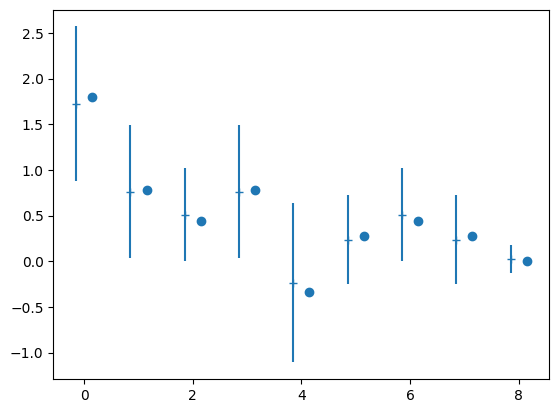

In [230]:
plt.errorbar(np.arange(net.N_particles)-0.15, means, yerr = np.sqrt(vars), linestyle = "", marker = "+")
plt.scatter(np.arange(net.N_particles)+0.15, mf_means)